尝试模拟画点的文件, 未完成

In [12]:
from tkinter import Tk, Canvas, Button, PhotoImage, filedialog
import keyboard
import pyautogui
from PIL import Image, ImageGrab
import win32api, win32gui
import pickle, time
import numpy as np
from tqdm import tqdm

In [2]:
def save_img(filename,v):
    f=open(filename,'wb')
    pickle.dump(v,f)
    f.close()
def load_img(filename):
    f=open(filename,'rb')
    r=pickle.load(f)
    f.close()
    return r

In [3]:
img = load_img('img.var') # 大42 中8 小4

In [16]:
target_img = Image.open('./test.jpg')
width, height = target_img.size
target_img = target_img.resize((round(width / 4), round(height / 4)), Image.ANTIALIAS)

In [21]:
low_img = target_img.convert('P', palette=Image.ADAPTIVE, colors=3)
target_img = low_img.convert('RGB', palette=Image.ADAPTIVE, colors=3)

In [22]:
tiw, tih = target_img.size
target_img_p = target_img.load()

In [43]:
diff_limit = 100  # 相似像素最大距离
last_p = (255, 255, 255)
last_result = (1769, 124)


def colors_diff(pixel_a, pixel_b):
    return np.square(pixel_a[0] - pixel_b[0]) + np.square(pixel_a[1] - pixel_b[1]) + np.square(pixel_a[2] - pixel_b[2])

point_size = 6  # 画笔大小
draw_area = 0.7  # 绘画区域比例
color_dic_temp = {}

# 绘画区域
start_x = round((width / 2 * draw_area) - (tiw / 2) + (width * (1 - draw_area) / 2))
start_y = round((height / 2 * draw_area) - (tih / 2) + (height * (1 - draw_area) / 2))

# 调色板
color_board = img.crop((1470, 25, 1770, 125))
color_board = color_board.load()

# 统计调色板颜色
colors = []
for x in range(300):
    for y in range(100):
        color3 = [color_board[x, y][0], color_board[x, y][1], color_board[x, y][2]]
        colors.append(color3)
colors = np.array(colors)

# 建立调色板字典
color_dic = {}
for x in range(300):
    for y in range(100):
        color_dic[color_board[x, y]] = (x + 1470, y + 25)
        
# 计算最接近的颜色 此方法速度快, 精确度较高, 但并不是最好结果
def closest(p, colors_all):
    p = np.array(p)
    distances = np.sqrt(np.sum((colors_all - p) ** 2, axis=1))
    index_of_smallest = np.where(distances == np.amin(distances))
    smallest_distance_color = colors[index_of_smallest]
    return smallest_distance_color
        
def find_color(p, colors_all):
    global last_p
    global last_result
    # 白色, 黄色
    if colors_diff((0, 0, 0), p) < diff_limit or colors_diff((255, 254, 246), p) < diff_limit:
        return None, None
    
    # 黑色
    if colors_diff((255, 255, 255), p) < diff_limit:
        return 1769, 124
    
    # 上一个
    if colors_diff(p, last_p) < diff_limit:
        return last_result
    
    # 扫描临时字典
    if p in color_dic_temp:
        return color_dic_temp[p]
    
    color = closest(p, colors_all)
    color = color[0]
    rx, ry = color_dic[(color[0], color[1], color[2])]
    color_dic_temp[p] = (rx, ry)
    last_p = p
    last_result = (rx, ry)
    return rx, ry


# 计算所有取色点
step = {}
for y in range(tih):
    for x in range(tiw):
        m, n = find_color(target_img_p[x, y], colors)
        if m is None:
            break
        else:
            # 记录操作步骤
            if not (m, n) in step:
                step[(m, n)] = []
            step[(m, n)].append((start_x + point_size * x, start_y + point_size * y))

# 排序, 先画颜色多的点
sort = sorted(step, key=lambda k: len(step[k]), reverse=True)

In [44]:
sort

[(1659, 28), (1710, 109), (1479, 116), (1474, 122)]

In [42]:
# 最大点间距倍数 默认为2 越大图像越模糊,速度越快
max_dot_pitch_multiple = 2

# 统计需要画的线
for the_color in tqdm(sort):
    last_point = (0, 0)
    lines = []
    line = {}
    for draw_point in step[the_color]:
        # 同一行 且 距离够近
        if draw_point[1] == last_point[1] and not abs(
                draw_point[0] - last_point[0]) > max_dot_pitch_multiple * point_size:
            line['end'] = draw_point
        else:
            if last_point[0] != 0:
                lines.append(line)
                line = {}
            line['start'] = draw_point
        last_point = draw_point
        
    # 画    
    for the_line in lines:
        draw(the_line['start'][0], the_line['start'][1], the_color)
        if 'end' in the_line:
            # time
            draw_line(the_line['start'][0], the_line['start'][1], the_line['end'][0], the_line['end'][1], the_color)

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

819 816
1065 822
657 834
657 840
1131 840
699 846
1083 846
711 858
1161 858
657 864
705 864
1173 864
657 870
1185 870
657 876
1191 876
657 882
1197 882
1761 882
657 888
1101 888
657 894
657 900
687 900
1107 900
1215 900
1773 900
657 906
687 906
765 906
1221 906
1779 906
657 912
687 912
741 912
759 912
777 912
1227 912
1779 912
657 918
687 918
735 918
753 918
783 918
1785 918
507 924
657 924
687 924
723 924
753 924
777 924
1221 924
507 930
657 930
705 930
723 930
777 930
1119 930
1221 930
1239 930
1791 930
507 936
639 936
657 936
705 936
777 936
1125 936
1215 936
1239 936
1275 936
1797 936
507 942
531 942
603 942
1101 942
1125 942
1227 942
1299 942
1797 942
507 948
531 948
1317 948
1803 948
501 954
525 954
1131 954
1323 954
1803 954
501 960
1131 960
1809 960
501 966
1137 966
501 972
717 972
1137 972
1365 972
1815 972
501 978
717 978
1137 978
1359 978
1377 978
1815 978
489 984
795 984
1137 984
1353 984
1821 984
477 990
1131 990
1353 990
1821 990
477 996
1131 996
1347 996
1827 996
471 100

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

1857 1068
429 1074
999 1074
1311 1074
1857 1074
423 1080


IndexError: image index out of range

In [33]:
def get_distance_from_point_to_line(point, line_point1, line_point2):
    #对于两点坐标为同一点时,返回点与点的距离
    if line_point1 == line_point2:
        point_array = np.array(point )
        point1_array = np.array(line_point1)
        return np.linalg.norm(point_array -point1_array )
    #计算直线的三个参数
    A = line_point2[1] - line_point1[1]
    B = line_point1[0] - line_point2[0]
    C = (line_point1[1] - line_point2[1]) * line_point1[0] + \
        (line_point2[0] - line_point1[0]) * line_point1[1]
    #根据点到直线的距离公式计算距离
    distance = np.abs(A * point[0] + B * point[1] + C) / (np.sqrt(A**2 + B**2))
    return distance

In [41]:
cu = 6
def draw(x, y, color):
    color = img.load()[color]
    global cu
    new_p[(x,y)] = color
    for rx in range(1,cu):
        for ry in range(1,cu):
            if np.sqrt(np.square(rx - x) + np.square(ry - y)) <= cu:
            try:
                new_p[(x+rx,y+ry)] = color
                new_p[(x+rx,y-ry)] = color
                new_p[(x-rx,y+ry)] = color
                new_p[(x-rx,y-ry)] = color
            except:
                pass
                
def draw_line(x1, y1, x2, y2, color):
    color = img.load()[color]
    global cu
    for rx in range(x1, x2):
        for ry in range(y1-cu,y2+cu):
            if get_distance_from_point_to_line((rx,ry),(x1,y1),(x2,y2))<=cu:
                try:
                    new_p[(rx,ry)] = color
                except:
                    pass

IndentationError: expected an indented block (Temp/ipykernel_5520/381449461.py, line 10)

In [ ]:
# for the_line in lines:
#     pyautogui.click(x=the_line['start'][0], y=the_line['start'][1])
#     if 'end' in the_line:
#         time = ((((the_line['end'][0] - the_line['start'][0]) ** 2) + (
#                     (the_line['end'][1] - the_line['start'][1]) ** 2)) ** 0.5) / point_size / 160
#         time = max(0.1, time)
#         pyautogui.dragTo(the_line['end'][0], the_line['end'][1], time, button='left')

In [31]:
new = Image.new('RGB', (1920, 1080), (255, 254, 246))
new_p = new.load()

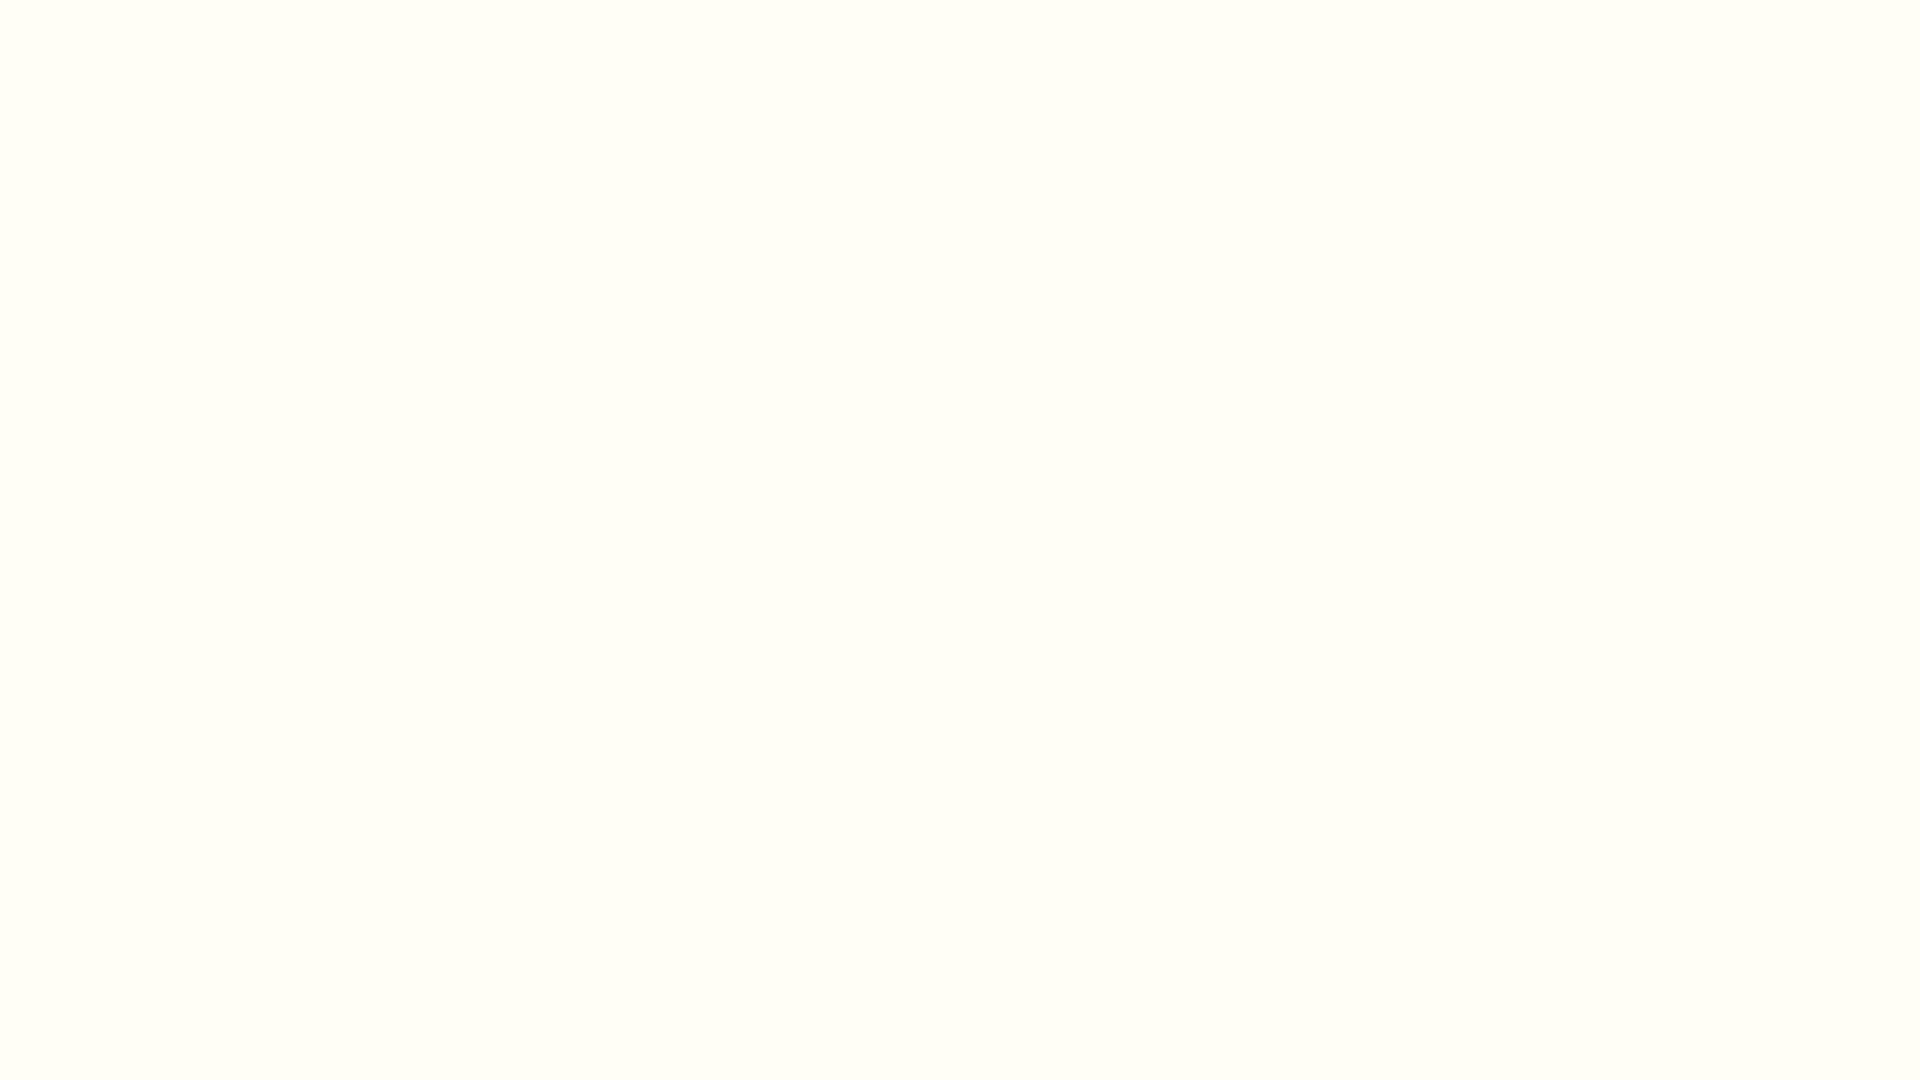

In [43]:
new

据说jit会更快, 待测试

In [16]:
from numba import jit
colors = np.array(colors)
color = np.array(color)

@jit
def closest(colors,color):
    distances = np.sqrt(np.sum((colors-color)**2,axis=1))
    index_of_smallest = np.where(distances==np.amin(distances))
    smallest_distance = colors[index_of_smallest]
    return smallest_distance 

NameError: name 'colors' is not defined

查看sort内的颜色

In [13]:
f=open('../bin/color_board.bin','rb')
color_board=pickle.load(f)
f.close()

In [8]:
sort = [(1624, 119), (1609, 114), (1522, 106), (1497, 41), (1530, 32)]

In [19]:
cbl = color_board.load()
color_array = []
for i in sort:
    i = list(i)
    color_array.append(cbl[((i[0] - 1470),(i[1] - 25))])

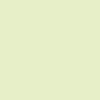

In [17]:
Image.new('RGB', (100, 100), (231, 239, 200))